In [2]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import matplotlib.pyplot as plt

import numpy as np
import cv2

#이미지 -> 배열로
def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x


def generate_cam(img_tensor, model, class_index, last_conv): #img_tensor:이미지 배열(224,224,3)
    """
    generate cam(class activation map)
    
    :param img_tensor: CNN model의 입력으로 사용될 image tensor
    :param model: 사용할 CNN model
        - softmax(+ dense) 이전의 layer가 GlobalAveragePooling2D이어야 함
        - dense(fc) layer로 구성되면 안됨 -> VGGNet과 같은 모델은 Dense layer를 GAP로 변경 후 재학습(re-train)시킨 후 적용
    :param class_index: cam을 얻고자 하는 class index
    :param last_conv: GAP 이전의 마지막 Conv layer 이름
    
    :return:
    cam: class activation map
        - shape는 last_conv layer의 feature map과 동일
    """

    model_input = model.input #(?,224,224,3)
    model_output = model.layers[-1].output #맨 마지막 출력 (?, 1000)

    # f_k(x, y) : 마지막 conv layer의 출력 feature map,GAP 직전 conv_layer model_summary 기준 res5c_branch2c
    f_k = model.get_layer(last_conv).output #(?,7,7,2048)

    # model의 입력에 대해서,
    # 마지막 conv layer의 출력(f_k) 계산
    get_output = K.function([model_input], [f_k])
    [last_conv_output] = get_output([img_tensor])

    # batch size가 포함되어 shape가 (1, width, height, k)이므로
    # (width, height, k)로 shape 변경
    # 여기서 width, height는 마지막 conv layer인 f_k feature map의 width와 height를 의미함
    last_conv_output = last_conv_output[0] #shape:(width, height, k) 여기서 k=2048

    # softmax(+ dense) layer와 GAP layer 사이의 weight matrix에서
    # class_index에 해당하는 class_weight_k(w^c_k) 계산
    # ex) w^2_1, w^2_2, w^2_3, ..., w^2_k
    class_weight_k = model.layers[-1].get_weights()[0][:, class_index]

    # 마지막 conv layer의 출력 feature map(last_conv_output)과
    # class_index에 해당하는 class_weight_k(w^c_k)를 k에 대응해서 weighted sum을 구함

    # feature map(last_conv_output)의 (width, height)로 초기화
    cam = np.zeros(dtype=np.float32, shape=last_conv_output.shape[0:2])
    for k, w in enumerate(class_weight_k):
        cam += w * last_conv_output[:, :, k]

    return cam


if __name__ == "__main__":
    img_width = 224
    img_height = 224

    model = ResNet50(weights='imagenet')
    print(model.summary())

    img_path = '/content/dog.jpg'
    img = load_image(path=img_path, target_size=(img_width, img_height))

    preds = model.predict(img)
    predicted_class = preds.argmax(axis=1)[0]
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("predicted top1 class:", predicted_class)
    print('Predicted:', decode_predictions(preds, top=1)[0])
    # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

    cam = generate_cam(img, model, predicted_class, 'res5c_branch2c')

    ## 최대값이 1이 되도록 normalize
    cam = cam / cam.max()
    cam = cam * 255
    print(cam)

    cam = cv2.resize(cam, (img_width, img_height))
    cam = np.uint8(cam)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_width, img_height))
    cv_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    fin = cv2.addWeighted(cv_cam, 0.7, img, 0.3, 0)
    

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

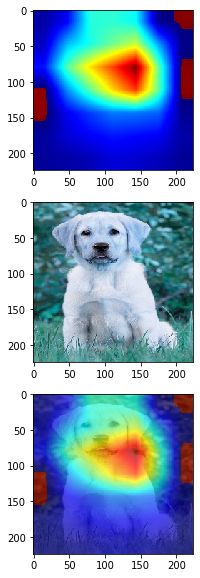

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(cv_cam,cv2.COLOR_BGR2RGB))
plt.subplot(3,1,2)
plt.imshow(img)
plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(fin,cv2.COLOR_BGR2RGB))

In [4]:
img_path = '/content/dog.jpg'
img = load_image(path=img_path, target_size=(img_width, img_height))
img.shape

(1, 224, 224, 3)

In [0]:
img = load_image('/content/dog.jpg')
preds = model.predict(img)
predicted_class = preds.argmax(axis=1)[0]


#generated_cam
model_input = model.input #(?,224,224,3)
model_output = model.layers[-1].output #맨 마지막 출력 (?, 1000)

    # f_k(x, y) : 마지막 conv layer의 출력 feature map,GAP 직전 conv_layer model_summary 기준 res5c_branch2c
f_k = model.get_layer('res5c_branch2c').output #(?,7,7,2048)

    # model의 입력에 대해서,
    # 마지막 conv layer의 출력(f_k) 계산
get_output = K.function([model_input], [f_k])
[last_conv_output] = get_output([img])

    # batch size가 포함되어 shape가 (1, width, height, k)이므로
    # (width, height, k)로 shape 변경
    # 여기서 width, height는 마지막 conv layer인 f_k feature map의 width와 height를 의미함
last_conv_output = last_conv_output[0] #shape:(width, height, k) 여기서 k=2048

    # softmax(+ dense) layer와 GAP layer 사이의 weight matrix에서
    # class_index에 해당하는 class_weight_k(w^c_k) 계산
    # ex) w^2_1, w^2_2, w^2_3, ..., w^2_k
class_weight_k = model.layers[-1].get_weights()[0][:, predicted_class] #(2048, )

    # 마지막 conv layer의 출력 feature map(last_conv_output)과
    # class_index에 해당하는 class_weight_k(w^c_k)를 k에 대응해서 weighted sum을 구함

    # feature map(last_conv_output)의 (width, height)로 초기화
cam = np.zeros(dtype=np.float32, shape=last_conv_output.shape[0:2]) #(7,7)
for k, w in enumerate(class_weight_k):
    cam += w * last_conv_output[:, :, k]

In [0]:
last_conv_output[:,:,1].shape

(7, 7)

In [0]:
class_weight_k.shape

(2048,)

In [0]:
cam.shape

(7, 7)